# Computational Politics: 
## Split Train and Test Set by Quarters

> * For time-series tutorial https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
> * Amazing plots and explanations: https://www.kaggle.com/headsortails/wiki-traffic-forecast-exploration-wtf-eda

In [49]:
import os
import dill
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
import datetime
from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score

#os.chdir("../ASUS/Desktop/Thesis")
dill.load_session('notebook_env.db')
DATA = DATA.drop(columns=['index','url','title','weekday','quarter'])
DATA['date'] = DATA['date'].astype('datetime64[ns]')

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
                 #color="red" if cm[i, j] > thresh else "black")
    #plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
DATA.head()

,date,n1146295,n1652858,n1652930,n3757016,n4509650,n3757022,n4509627,n4509607,n3757020,...,year,weekdays,QTR,doc_release,policy_explained,0,1,2,3,4
0,2002-05-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2002,5,2,0,1,0.244166,0.258252,0.183404,0.264747,0.049431
1,2002-05-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2002,5,2,0,1,0.244177,0.258252,0.183398,0.264742,0.049431
2,2003-03-20,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2003,4,1,0,1,0.060923,0.087503,0.052136,0.240123,0.559315
3,2003-03-20,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2003,4,1,0,1,0.060926,0.087500,0.052136,0.240122,0.559316
4,2004-02-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2004,2,1,0,1,0.038290,0.049918,0.033300,0.647976,0.230516


# Buidling the Model using PCI techniques

> * https://github.com/PSLmodels/PCI/blob/master/Notebooks/Policy_Change_Index_A_Simulated_Example.ipynb
> * Confirmed Kaggle works: https://www.kaggle.com/jroachel/tensorflow-tutorial/edit

# RandomForest Model

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import seaborn as sns
import time


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [50]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

col_index = [      'date',         'n1146295',         'n1652858',
               'n1652930',         'n3757016',         'n4509650',
               'n3757022',         'n4509627',         'n4509607',
               'n3757020',         'n4509636',         'n3757019',
               'n3757018',         'n3757021',         'n3757017',
               'n1653018',         'n1653100',         'n3767755',
              'character',         'n1146557',         'n1146624',
               'n1146592',         'n3917132',         'n4545264',
               'n1146562',         'n1146650',         'n1146655',
               'n1146582', 'Important_cCodes', 'n_posts_that_day',
                    'day',             'week',            'month',
                   'year',         'weekdays',              'QTR',
            'doc_release', 'policy_explained',                  '0',
                        '1',                  '2',                  '3',
                        '4']
DATA.set_index(col_index)
DATA.head()

,date,n1146295,n1652858,n1652930,n3757016,n4509650,n3757022,n4509627,n4509607,n3757020,...,year,weekdays,QTR,doc_release,policy_explained,0,1,2,3,4
0,2002-05-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2002,5,2,0,1,0.244166,0.258252,0.183404,0.264747,0.049431
1,2002-05-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2002,5,2,0,1,0.244177,0.258252,0.183398,0.264742,0.049431
2,2003-03-20,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2003,4,1,0,1,0.060923,0.087503,0.052136,0.240123,0.559315
3,2003-03-20,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2003,4,1,0,1,0.060926,0.087500,0.052136,0.240122,0.559316
4,2004-02-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2004,2,1,0,1,0.038290,0.049918,0.033300,0.647976,0.230516


In [43]:
target = ['doc_release']
predictors = [
 #'date',      # Groupby() can only be performed after 'policy_explained' and 'doc_released' exist
# 'n1146295', # agg('sum')
# 'n1652858', 
# 'n1652930',
# 'n3757016',
# 'n4509650',
# 'n3757022',
# 'n4509627',
# 'n4509607',
# 'n3757020',
# 'n4509636',
# 'n3757019',
# 'n3757018',
# 'n3757021',
# 'n3757017',
# 'n1653018',
# 'n1653100',
# 'n3767755',
# 'character',
# 'n1146557',
# 'n1146624',
# 'n1146592',
# 'n3917132',
# 'n4545264',
# 'n1146562',
# 'n1146650',
# 'n1146655',
# 'n1146582', # agg('sum')
 'Important_cCodes',
 'n_posts_that_day', # agg('sum')
 'day',      # same
 'week',     # same
 'month',    # same
 'year',     # same
 'weekdays', # same
 'QTR',      # same
# 'doc_release',    # agg('sum') even if 2 out 4 posts on same day are released docs.
 'policy_explained', # agg('sum')
 '0', # concat(title contents in one row)
 '1', # concat(title contents in one row)
 '2', # concat(title contents in one row)
 '3', # concat(title contents in one row)
 '4']
predictors

['Important_cCodes',
 'n_posts_that_day',
 'day',
 'week',
 'month',
 'year',
 'weekdays',
 'QTR',
 'policy_explained',
 '0',
 '1',
 '2',
 '3',
 '4']

## By Groupby(date), is there loss of information?
> * when concat(title contents), associating 'webcodes', which is summed up into one row, this association will be lost in the concatenation? Each post has webcodes associating with contents (topics)
>> - when tokenizing, that will interfere each post's topic_distribution, and results in "daily topical distributions" instead. Will this be more understandable by the public? --if i train model for the last year/quarter, how will this predict next days' Policy document_release? (which won't be a classification prob anymore, but a regression. 
> * confirm that webCodes information will not likely to be lost because aggBy(count) will ensure WebCodes will be documented with binary in appropriate columns. 

In [69]:
train_df, val_df = train_test_split(DATA, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

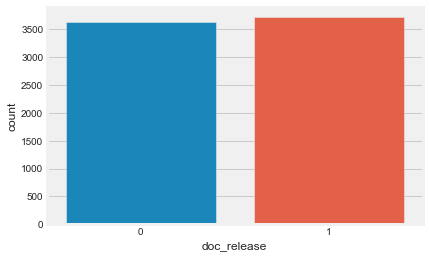

In [70]:
sns.countplot(train_df['doc_release']) # great! no minorties
sns.set_style('whitegrid')

In [71]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [72]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

In [73]:
preds = clf.predict(val_df[predictors])

In [74]:
preds

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

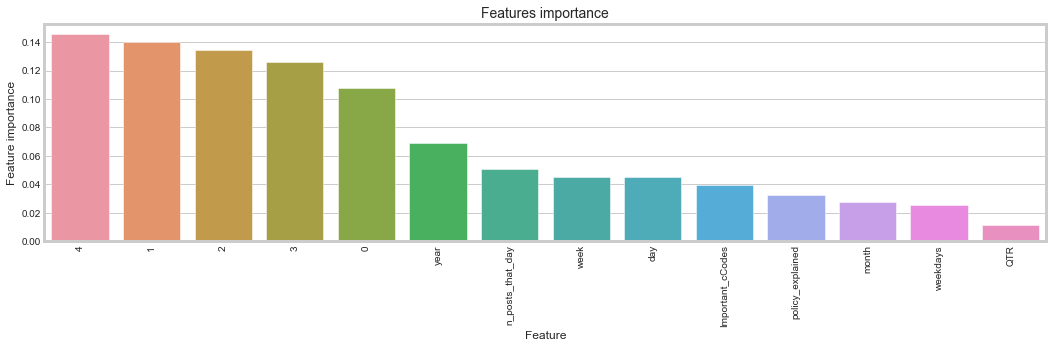

In [75]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [76]:
roc_auc_score(val_df[target].values, preds)

0.8189787655953069

confusion matrix:
[[734 176]
 [157 774]]
classification report:
             precision    recall  f1-score   support

          0       0.82      0.81      0.82       910
          1       0.81      0.83      0.82       931

avg / total       0.82      0.82      0.82      1841

Normalized confusion matrix
[[0.80659341 0.19340659]
 [0.16863588 0.83136412]]


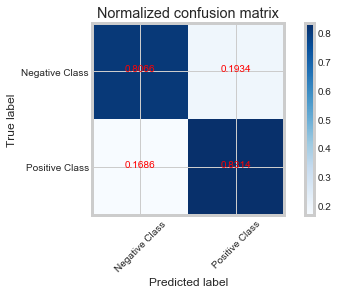

In [77]:

cm = confusion_matrix(val_df[target].values, preds)
print('confusion matrix:')
print(cm)
#print('\n')
print('classification report:')
print(classification_report(val_df[target].values, preds))
plot_confusion_matrix(cm, classes=['Negative Class', 'Positive Class'], normalize=True, title='Normalized confusion matrix')

# LIGHTBOOST

In [55]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':50, # because training data is sightly unbalanced 
         }

params2 = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [56]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [57]:
X_test = val_df[predictors]
#X_test = test_df.drop('ID_code',axis=1)
X = train_df[predictors]
y = train_df[target]

### Train wit param 1

In [58]:
oof = np.zeros(len(X))
prediction = np.zeros(len(X_test))
scores = []
feature_importance = pd.DataFrame()
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                    valid_sets = [train_data, valid_data],verbose_eval=300,early_stopping_rounds = 200)
            
    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Fold 0 started at Sun Feb 24 00:55:52 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.89432	valid_1's auc: 0.871049
[600]	training's auc: 0.917855	valid_1's auc: 0.882891
[900]	training's auc: 0.932784	valid_1's auc: 0.888398
[1200]	training's auc: 0.942471	valid_1's auc: 0.890757
[1500]	training's auc: 0.950293	valid_1's auc: 0.893305
[1800]	training's auc: 0.956029	valid_1's auc: 0.89466
[2100]	training's auc: 0.961293	valid_1's auc: 0.895762
Early stopping, best iteration is:
[2197]	training's auc: 0.962728	valid_1's auc: 0.896778
Fold 1 started at Sun Feb 24 00:55:56 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.894934	valid_1's auc: 0.865913
[600]	training's auc: 0.918346	valid_1's auc: 0.878146
[900]	training's auc: 0.933469	valid_1's auc: 0.886679
[1200]	training's auc: 0.943817	valid_1's auc: 0.891056
[1500]	training's auc: 0.951917	valid_1's auc: 0.893842
[1800]	training's auc: 0.957971	v

### Train wit param 2

In [59]:
oof = np.zeros(len(X))
prediction = np.zeros(len(X_test))
scores = []
feature_importance = pd.DataFrame()
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params2,train_data,num_boost_round=20000,
                    valid_sets = [train_data, valid_data],verbose_eval=300,early_stopping_rounds = 200)
            
    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Fold 0 started at Sun Feb 24 00:57:41 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's auc: 0.877161	valid_1's auc: 0.854568
[600]	training's auc: 0.898702	valid_1's auc: 0.869421
[900]	training's auc: 0.910598	valid_1's auc: 0.877034
[1200]	training's auc: 0.919719	valid_1's auc: 0.882561
[1500]	training's auc: 0.926005	valid_1's auc: 0.88541
[1800]	training's auc: 0.931991	valid_1's auc: 0.888327
[2100]	training's auc: 0.936699	valid_1's auc: 0.890274
[2400]	training's auc: 0.940707	valid_1's auc: 0.891256
[2700]	training's auc: 0.944217	valid_1's auc: 0.892587
[3000]	training's auc: 0.947568	valid_1's auc: 0.893472
[3300]	training's auc: 0.950308	valid_1's auc: 0.894058
[3600]	training's auc: 0.952734	valid_1's auc: 0.894771
[3900]	training's auc: 0.955076	valid_1's auc: 0.895454
[4200]	training's auc: 0.95716	valid_1's auc: 0.895959
Early stopping, best iteration is:
[4215]	training's auc: 0.957301	valid_1's auc: 0.896056
Fold 1 started at Sun Fe

# Start Testing Windows: 6 months Train, next month 7th month Testing
> * There will be monthly output of CIPI, which means the training algo will train from 6 months (or 3 months) window from a definite date at the end of each month, and output the index score. 

### ***Driving Questions:***
> * Will these Ministry Posts behave like traffic data? 
> * Will the Index measure policy tightening or 
> * Policy data should be driven by:
>> - Major Events like Trade-war
>> - 5-year plans
>> - Macro-Economic Indicators (Inflation,Demand, Supply, etc.) 

### ***DATA from Ministries:***
> * Should MOFCOM,MIIT, NRCD have their own indices?
> * Should the Indices be defined by Topics? ***If Indices split by topics, then if topics reflect 'tightening', 'standardize', 'loosening' Word_freq, then we can show a time series of each topics fluctuating***.
> * Should the Indices be defined by Industries (finance, manufacture, etc)?

### ***Prediction Training （2 methods)***
> * Train on posts or on days (aggregate information groupby 'date')? ***which one will answer the question is industrial policy tightening up in my sectors?*** which implies knowing the topics and specialized vocabulary, and metric of frequency (‘扩大，扩张，控制，限制’）
> * ***1. Posts***: cost* hard to conduct Seasonal trends tests (maybe the most important?) | Benefits* classification problem, no extra work on concat chinese text, ***answers whether or not a post is going to be published under Policy section***.
> * ***2. Dates***: cost* tons of data cleaning work, regression problem, |benefits* ***answers how many policies will be outputed in the next day, month, quarter?*** 

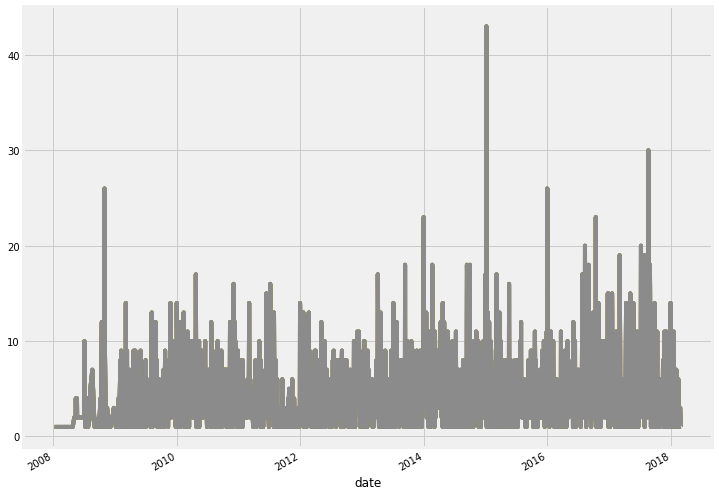

In [187]:
AGG_By_date = DATA[(DATA['date'] >= "2008-01-01") & (DATA['date'] <= "2018-03-01" )].groupby("date").agg('count')
AGG_By_date.tail()
AGG_By_date['0'].plot()
AGG_By_date['1'].plot()
AGG_By_date['2'].plot()
AGG_By_date['3'].plot()
AGG_By_date['4'].plot()

> * Freq Plot indicates that not much posts published before 2008, ***thus we should train the model after 2008***.
> * Spikes at 2009, 2014, 2015, 2016, 2018ish
> * 2015 has record high of 45 posts in on day. what is up?

# Now, for decomposition...for frequency of posts per day

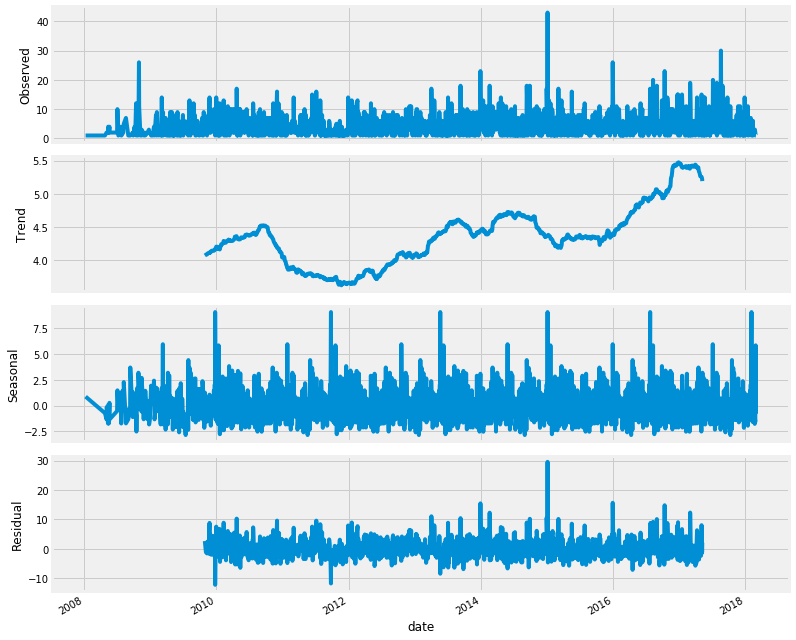

In [188]:
rcParams['figure.figsize'] = 11, 9
decomposed_index_volume = sm.tsa.seasonal_decompose(AGG_By_date["0"],freq=360) # The frequncy is annual
figure = decomposed_index_volume.plot()
plt.show()

### Fig below White noise has...

> * Constant mean
> * Constant variance
> * Zero auto-correlation at all lags

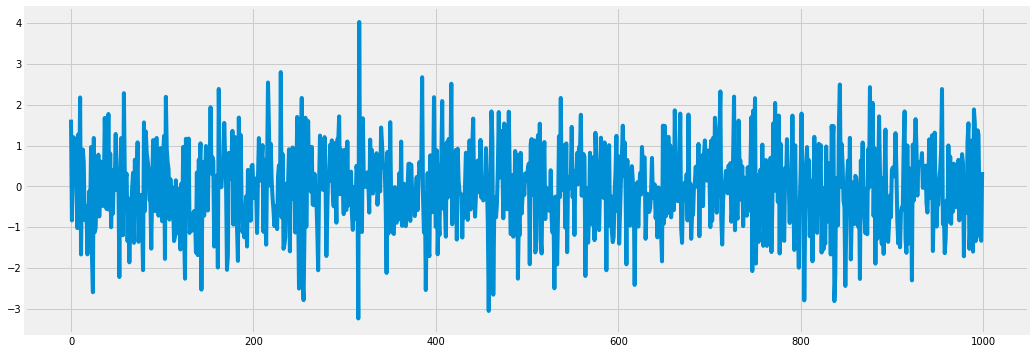

In [183]:
rcParams['figure.figsize'] = 16, 6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise) # not in our data....

### * Define Functions

In [32]:
def get_NdaysAgo_Data_from(today,date_col,df, days):
    """Retrieves data N-days ago. 
    * today: format = 'YYYY-MM-DD'
    * date_col:
    * days: n days ago 
    return: df with desired time frame
    """
    today = pd.to_datetime(today)
    begin = today - pd.offsets.Day(days)
    return(df[(date_col < today) & (date_col > begin)])

def get_NdaysAhead_Data_from(today,date_col,df, days):
    """Retrieves data N-days ago. 
    * today: format = 'YYYY-MM-DD'
    * date_col:
    * days: n days in the future 
    return: df with desired time frame
    """
    today = pd.to_datetime(today)
    begin = today + pd.offsets.Day(days)
    return(df[(date_col >= today) & (date_col <= begin)])

In [34]:
get_NdaysAhead_Data_from("2008-06-30",DATA.date, DATA, 30)
#DATA[DATA['date']==pd.to_datetime("2009-06-15")]

,date,n1146295,n1652858,n1652930,n3757016,n4509650,n3757022,n4509627,n4509607,n3757020,...,year,weekdays,QTR,doc_release,policy_explained,0,1,2,3,4
48,2008-07-01,0.010705,0.031790,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2008,2,3,0,0,0.244182,0.258252,0.183396,0.264740,0.049431
49,2008-07-01,0.014273,0.042387,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2008,2,3,0,0,0.244464,0.258258,0.183289,0.264559,0.049430
50,2008-07-03,0.010705,0.031790,0.229283,0.0,0.0,0.0,0.000000,0.0,1.233077,...,2008,4,3,1,0,0.244503,0.258261,0.183284,0.264521,0.049430
51,2008-07-03,0.010705,0.031790,0.229283,0.0,0.0,0.0,0.000000,0.0,1.233077,...,2008,4,3,1,0,0.244464,0.258258,0.183290,0.264559,0.049430
52,2008-07-03,0.010705,0.031790,0.229283,0.0,0.0,0.0,0.000000,0.0,1.233077,...,2008,4,3,1,0,0.244084,0.258250,0.183434,0.264802,0.049431
53,2008-07-03,0.010705,0.031790,0.229283,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2008,4,3,1,0,0.244190,0.258252,0.183393,0.264734,0.049431
54,2008-07-03,0.014273,0.042387,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,2008,4,3,0,0,0.244103,0.258250,0.183426,0.264790,0.049431
55,2008-07-03,0.010705,0.031790,0.229283,0.0,0.0,0.0,0.000000,0.0,1.233077,...,2008,4,3,1,0,0.244126,0.258251,0.183417,0.264775,0.049431
56,2008-07-03,0.010705,0.031790,0.229283,0.0,0.0,0.0,0.000000,0.0,1.233077,...,2008,4,3,1,0,0.244127,0.258251,0.183417,0.264775,0.049431
57,2008-07-03,0.010705,0.031790,0.229283,0.0,0.0,0.0,0.000000,0.0,1.233077,...,2008,4,3,1,0,0.244160,0.258251,0.183404,0.264754,0.049431


## Making an Big Enchilada Index that CIPI_monthly(today) = graphs index for every month 

In [39]:
# split DATAset into timeseries train and test set.
train = [] 
#Y_train = []
val = [] 
#Y_val = []
dates_to_index = ["2008-06-30","2008-12-31","2009-06-30","2009-12-31","2010-06-30","2010-12-31",
                 "2011-06-30","2011-12-31","2012-06-30","2012-12-31","2013-06-30","2013-12-31",
                 "2014-06-30","2014-12-31","2015-06-30","2015-12-31","2016-06-30","2016-12-31",
                 "2017-06-30","2017-12-31","2018-06-30","2018-12-31"]
for t in dates_to_index:
    tmp = get_NdaysAgo_Data_from(t,DATA.date, DATA[predictors], 180) # train last 6 months
    train.append(tmp)

    tmp_val = get_NdaysAhead_Data_from(t,DATA.date, DATA[], 30)
    val.append(tmp_val)
    
# for t in range(5,10):
#     tmp_x, tmp_y = gen_data(n,signal=8)
#     X_train.append(tmp_x)
#     Y_train.append(tmp_y)
    
#     tmp_x, tmp_y = gen_data(n,signal=8)
#     X_val.append(tmp_x)
#     Y_val.append(tmp_y)

#output = np.zeros((9,4)
#train.shape
train[0]

,Important_cCodes,n_posts_that_day,day,week,month,year,weekdays,QTR,policy_explained,0,1,2,3,4
28,0,1,9,2,1,2008,3,1,0,0.244126,0.258251,0.183418,0.264775,0.049431
29,0,1,25,17,4,2008,5,2,0,0.244419,0.258258,0.183313,0.264579,0.049430
30,0,2,4,18,5,2008,7,2,0,0.244307,0.258258,0.183360,0.264644,0.049431
31,0,2,4,18,5,2008,7,2,0,0.244158,0.258251,0.183405,0.264755,0.049431
32,0,2,5,18,5,2008,1,2,0,0.244484,0.258258,0.183281,0.264546,0.049430
33,0,2,5,18,5,2008,1,2,0,0.244194,0.258252,0.183391,0.264732,0.049431
34,0,2,12,19,5,2008,1,2,0,0.244173,0.258257,0.183422,0.264717,0.049431
35,0,2,12,19,5,2008,1,2,0,0.244129,0.258251,0.183416,0.264774,0.049431
36,1,4,13,20,5,2008,2,2,0,0.244492,0.258259,0.183281,0.264539,0.049430
37,1,4,13,20,5,2008,2,2,0,0.244287,0.258257,0.183368,0.264657,0.049430


In [ ]:
output = np.zeros((9,4))

for i in range(0,9):
    print("Period:" + str(i))
    tmp = PCI(X_train[i], Y_train[i], X_val[i], Y_val[i] ,X_val[i+1], Y_val[i+1]) 
    tmp.insert(0,i+1)
    output[i] = tmp
    print(output[i])

In [ ]:
# 
train_df = get_NdaysAgo_Data_from("2008-07-01",DATA.date, DATA, 180) # train last 6 months
val_df = get_NdaysAgo_Data_from("2008-08-01",DATA.date, DATA, 30) # train last 1 months
#train_df, val_df = train_test_split(TRAIN, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )
X_train = train_df[predictors]
Y_train = train_df[target]
X_val = val_df[predictors]
Y_val = val_df[target]
X_fut = X_val[i+1]
Y_fut = Y_val[i+1]
tmp = PCI(X_train, Y_train, X_val, Y_val , X_fut, Y_fut) 
# OUTPUTS:
#500/500 [==============================] - 0s 40us/step
#500/500 [==============================] - 0s 40us/step
# [1.    1.    0.998 0.002]

# Resources for Time-series Classifiers
> * https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
> * Dynamic Time Warping w/KNN: 
>> - https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping, 
>> - https://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb
> * RNN: Try whether GPU on kaggle can run CPI's codes CUDA GPU
>> - https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series
>> - https://github.com/denis-smirnov/tsc-with-rnn
>> - https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification
>> - https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795 (for learning)
>> - Good code for LSTM (RNN): https://github.com/shamimsa/multivariate_timeseries_classification/blob/master/Multivariate_TimeSeries_Event_Detection.ipynb
>> - https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [12]:
from __future__ import division
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import itertools
from math import floor, ceil
from numpy import random
import tsfresh
from sklearn import preprocessing
from tsfresh.feature_extraction.settings import MinimalFCParameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score
import matplotlib.pyplot as plt
from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Activation, Bidirectional, Dropout
from keras.utils import to_categorical
from sklearn.grid_search import GridSearchCV
from keras.preprocessing import sequence

In [22]:
 list(train_df.columns)

['date',
 'n1146295',
 'n1652858',
 'n1652930',
 'n3757016',
 'n4509650',
 'n3757022',
 'n4509627',
 'n4509607',
 'n3757020',
 'n4509636',
 'n3757019',
 'n3757018',
 'n3757021',
 'n3757017',
 'n1653018',
 'n1653100',
 'n3767755',
 'character',
 'n1146557',
 'n1146624',
 'n1146592',
 'n3917132',
 'n4545264',
 'n1146562',
 'n1146650',
 'n1146655',
 'n1146582',
 'Important_cCodes',
 'n_posts_that_day',
 'day',
 'week',
 'month',
 'year',
 'weekdays',
 'QTR',
 'doc_release',
 'policy_explained',
 '0',
 '1',
 '2',
 '3',
 '4']

### Normalize standardize data

In [80]:
train = train_df[predictors]
test = val_df[predictors]

# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Get column names
col_names = list(train.columns.values)
print(col_names)
cols_to_norm = col_names[1:] # Columns to standardize

# Fit training data on the scaler object
fitted_scaler = scaler.fit(train[cols_to_norm])
print(scaler)
train[cols_to_norm] = fitted_scaler.transform(train[cols_to_norm])
print(train.head())

# Use the scalar object fitted on training data to standardize the test set
test[cols_to_norm] = fitted_scaler.transform(test[cols_to_norm])
print(test.head())

['Important_cCodes', 'n_posts_that_day', 'day', 'week', 'month', 'year', 'weekdays', 'QTR', 'policy_explained', '0', '1', '2', '3', '4']
StandardScaler(copy=True, with_mean=True, with_std=True)
      Important_cCodes  n_posts_that_day       day      week     month  \
4287                 1          3.010145  1.538844  1.653507  1.577782   
8637                 0          0.727538  0.738816  1.328321  1.291161   
3477                 0         -0.033331 -0.975530 -1.338198 -1.288435   
1705                 0          0.537321 -0.404082  1.523433  1.577782   
6552                 0          0.156887  1.310265 -0.882939 -1.001814   

          year  weekdays       QTR  policy_explained         0         1  \
4287 -0.204908 -1.406303  1.344632         -0.181186  1.663969  1.362489   
8637  1.234189  0.537596  1.344632         -0.181186 -0.784272  0.778533   
3477 -0.204908  1.185562 -1.353673         -0.181186 -0.613678 -0.707121   
1705 -1.284231 -1.406303  1.344632         -0.181186 -0.5

In [81]:
X_train = np.array(train, dtype=float)
X_train.shape

(7362, 14)

In [75]:
nb_samples_train = len(train)
nb_samples_test = len(test)
nb_timestps = len(train)
nb_feat = len(train.columns)

X_train = np.zeros((nb_samples_train, nb_timestps, nb_feat))
X_test = np.zeros((nb_samples_test, nb_timestps, nb_feat))

# Create a mapper to map the time series IDs to indices in the 3-D array for the train and test set
TrainId_mapper = dict(zip(train_ids,range(train_sz)))
TestId_mapper = dict(zip(test_ids,range(test_sz)))

grouped_train = train.groupby('date')
grouped_test = test.groupby('date')


# Fill up the entries in the train and test data 3d array
# train data
for ID in train_dates:
    grp_train = grouped_train.get_group(ID).reset_index(drop=True).drop(['date'],axis=1)
    X_train[TrainId_mapper[ID],:,:] = grp_train.as_matrix()
        
# # # Test data
for ID in test_dates:
    grp_test = grouped_test.get_group(ID).reset_index(drop=True).drop(['date'],axis=1)
    X_test[TestId_mapper[ID],:,:] = grp_test.as_matrix()
    
# print(X_train.shape) 
# print(X_train) 
# print('\n')
# print(X_test.shape) 
# print(X_test)
X_train[0]

MemoryError: 

In [67]:
train_dates = list(set(train['date'].tolist()))
test_dates = list(set(test['date'].tolist()))

In [42]:
# ONE-HOT ENCODING, required by Keras LMST
num_classes = 2
y_train = train_df[target].values
y_test = val_df[target].values
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

y_train
#print(y_test.shape)
# Define LSTM
train = train_df[predictors].as_matrix()
test = val_df[predictors].as_matrix()

## Tuning Parameters

In [ ]:
# Define LSTM
train = train_df[predictors].as_matrix()
test = val_df[predictors].as_matrix()
BATCH_SIZE = 8
nb_classes = 2
input_layer = Input(batch_shape = (None, nb_timestps, nb_feat))
lstm_layer = Bidirectional(LSTM(units=7362))(input_layer)
output_layer = Dense(nb_classes, activation="sigmoid")(lstm_layer)

#opt = optimizers.Adam(lr=0.001)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy',
              optimizer='adam')
model.summary()

# Fit LSTM
EPOCH_SIZE = 30
model.fit(train, y_train, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE)

## Predict and Evaluate

In [ ]:
# PREDICTION
y_pred = np.argmax(model.predict(test),axis=1)
accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(cm)
#print('\n')
print('classification report:')
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm, classes=['Negative Class', 'Positive Class'], normalize=True, title='Normalized confusion matrix')

NameError: name 'y_test' is not defined

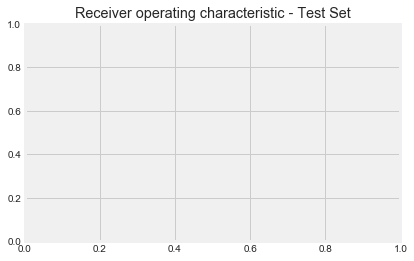

In [65]:
def plot_roc_curve_lstm(model, X_test, Y_test):
    probas_ = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC Curve (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
plt.title('Receiver operating characteristic - Test Set')
plot_roc_curve_lstm(model,X_test,y_test)

# ArturusKaggle 1st place Time Series RNN 

In [49]:
import pandas as pd
import numpy as np
import os.path
import os
import argparse

#from feeder import VarFeeder
import numba
from typing import Tuple, Dict, Collection, List

In [154]:
pd.to_datetime("2013-12-12") - pd.to_datetime("2013-12-11")
#DATA[DATA.dtypes == "datetime64[ns]"]
DATA.loc[:, DATA.dtypes == np.datetime64]
DATA.select_dtypes(include=['datetime64'])
DATA['date'][0] - DATA['date'][9000] 


Timedelta('-5845 days +00:00:00')

In [155]:
#@numba.jit(nopython=True)
def single_autocorr(series, lag):
    """
    Autocorrelation for single data series
    :param series: traffic series
    :param lag: lag, days
    :return:
    """
    s1 = series[lag:] # take out the first lag days of the series
    s2 = series[:-lag]# take out the last lag days of the series
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

#@numba.jit(nopython=True)
def batch_autocorr(data, lag, starts, ends, threshold, backoffset=0):
    """
    Calculate autocorrelation for batch (many time series at once)
    :param data: Time series, shape [n_pages, n_days]
    :param lag: Autocorrelation lag days 'int'
    :param starts: Start index for each series "date"
    :param ends: End index for each series "date"
    :param threshold: Minimum support (ratio of time series length to lag) to calculate meaningful autocorrelation.
    :param backoffset: Offset from the series end, days.
    :return: autocorrelation, shape [n_series]. If series is too short (support less than threshold),
    autocorrelation value is NaN
    """
    n_series = data.shape[1]
    n_days = data.shape[0]
    max_end = n_days - backoffset
    corr = np.empty(n_series, dtype=np.float64)
    support = np.empty(n_series, dtype=np.float64)
    for i in range(n_series):
        series = data[data.columns[i]]
        end = min(ends, max_end)
        real_len = end - starts
        support[i] = real_len/lag
        if support[i] > threshold:
            series = series[starts:end]
            c_365 = single_autocorr(series, lag)
            c_364 = single_autocorr(series, lag-1)
            c_366 = single_autocorr(series, lag+1)
            # Average value between exact lag and two nearest neighborhs for smoothness
            corr[i] = 0.5 * c_365 + 0.25 * c_364 + 0.25 * c_366
        else:
            corr[i] = np.NaN
    return corr , support


def prepare_data(start, end, valid_threshold) -> Tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
    """
    Reads source data, calculates start and end of each series, drops bad series, calculates log1p(series)
    :param start: start date of effective time interval, can be None to start from beginning
    :param end: end date of effective time interval, can be None to return all data
    :param valid_threshold: minimal ratio of series real length to entire (end-start) interval. Series dropped if
    ratio is less than threshold
    :return: tuple(log1p(series), nans, series start, series end)
    """
    df = read_x(start, end)
    starts, ends = find_start_end(df.values)
    # boolean mask for bad (too short) series
    page_mask = (ends - starts) / df.shape[1] < valid_threshold
    print("Masked %d pages from %d" % (page_mask.sum(), len(df)))
    inv_mask = ~page_mask
    df = df[inv_mask]
    nans = pd.isnull(df)
    return np.log1p(df.fillna(0)), nans, starts[inv_mask], ends[inv_mask]

def lag_indexes(begin, end) -> List[pd.Series]:
    """
    Calculates indexes for 3, 6, 9, 12 months backward lag for the given date range
    :param begin: start of date range
    :param end: end of date range
    :return: List of 4 Series, one for each lag. For each Series, index is date in range(begin, end), value is an index
     of target (lagged) date in a same Series. If target date is out of (begin,end) range, index is -1
    """
    dr = pd.date_range(begin, end)
    # key is date, value is day index
    base_index = pd.Series(np.arange(0, len(dr)), index=dr)

    def lag(offset):
        dates = dr - offset
        return pd.Series(data=base_index.loc[dates].fillna(-1).astype(np.int16).values, index=dr)

    return [lag(pd.DateOffset(months=m)) for m in (3, 6, 9, 12)]

In [133]:
starts = DATA['date'][0]
ends = DATA['date'][len(DATA)-1]
lag = 2
#batch_autocorr(DATA[predictors], lag, start, ends, 3)

# Yearly(annual) autocorrelation
raw_year_autocorr = batch_autocorr(DATA[predictors], 365, starts, ends, 1.5)
year_unknown_pct = np.sum(np.isnan(raw_year_autocorr))/len(raw_year_autocorr)  # type: float
year_unknown_pct   

# Quarterly autocorrelation
raw_quarter_autocorr = batch_autocorr(DATA[predictors], int(round(365.25/4)), starts, ends, 2)
quarter_unknown_pct = np.sum(np.isnan(raw_quarter_autocorr)) / len(raw_quarter_autocorr)  # type: float

TypeError: Cannot compare type 'Timestamp' with type 'int'

In [165]:
for i in list(DATA['year'].unique()):
    print(i,len(DATA[DATA['year']==i]))

# how do we do AC by posts?

2002 2
2003 2
2004 4
2005 5
2006 13
2007 2
2008 165
2009 586
2010 979
2011 696
2012 896
2013 961
2014 1011
2015 1023
2016 1197
2017 1194
2018 467


In [166]:
DATA.head()

,date,n1146295,n1652858,n1652930,n3757016,n4509650,n3757022,n4509627,n4509607,n3757020,...,year,weekdays,QTR,doc_release,policy_explained,0,1,2,3,4
0,2002-05-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2002,5,2,0,1,0.244455,0.258260,0.183302,0.264553,0.049430
1,2002-05-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2002,5,2,0,1,0.244529,0.258259,0.183263,0.264519,0.049430
2,2003-03-20,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2003,4,1,0,1,0.244197,0.258252,0.183390,0.264730,0.049431
3,2003-03-20,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2003,4,1,0,1,0.244176,0.258252,0.183399,0.264743,0.049431
4,2004-02-24,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2004,2,1,0,1,0.244143,0.258251,0.183411,0.264765,0.049431


### problem with yearly and quarterly autocorrelations:
> * the original dataset is not grouped by year and agg
> * this is hard to divide by 365 days to detect auto cor, we can only detect signals from sequential posts. 
> * two choices: 1) detect AC group by date, agg('count') on section_codes, or 2) detect AC by posts segemented by specific number of posts
>> - GroupBy date: can agg(WebCodes with TermFreq), 

In [167]:
list(DATA)

['date',
 'n1146295',
 'n1652858',
 'n1652930',
 'n3757016',
 'n4509650',
 'n3757022',
 'n4509627',
 'n4509607',
 'n3757020',
 'n4509636',
 'n3757019',
 'n3757018',
 'n3757021',
 'n3757017',
 'n1653018',
 'n1653100',
 'n3767755',
 'character',
 'n1146557',
 'n1146624',
 'n1146592',
 'n3917132',
 'n4545264',
 'n1146562',
 'n1146650',
 'n1146655',
 'n1146582',
 'Important_cCodes',
 'n_posts_that_day',
 'day',
 'week',
 'month',
 'year',
 'weekdays',
 'QTR',
 'doc_release',
 'policy_explained',
 '0',
 '1',
 '2',
 '3',
 '4']